In [28]:
!conda install -y -c plotly plotly-orca

Solving environment: done

## Package Plan ##

  environment location: //anaconda3

  added / updated specs:
    - plotly-orca


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2020.4.5.1         |           py37_0         155 KB
    openssl-1.1.1f             |       h1de35cc_0         2.2 MB
    plotly-orca-1.3.1          |                1        56.8 MB  plotly
    ------------------------------------------------------------
                                           Total:        59.1 MB

The following NEW packages will be INSTALLED:

  plotly-orca        plotly/osx-64::plotly-orca-1.3.1-1

The following packages will be UPDATED:

  certifi                                 2019.11.28-py37_0 --> 2020.4.5.1-py37_0
  openssl                                 1.1.1e-h1de35cc_0 --> 1.1.1f-h1de35cc_0



plotly-orca-1.3.1    | 56.8 MB   | ##################################### | 100% 


In [23]:

import sys
!{sys.executable} -m pip install plotly-orca
# !{sys.executable} -m pip install keras

ERROR: Could not find a version that satisfies the requirement plotly-orca (from versions: none)
ERROR: No matching distribution found for plotly-orca


In [30]:
import pandas as pd
import matplotlib.pyplot as plt


import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# predefine color pallette alias
cnf = 'grey' # confirmed
dth = 'red' # death
rec = 'lightgreen' # recovered
act = 'orange' # active


## Train / Test Data

In [3]:
train_df = pd.read_csv('train.csv')

test_df = pd.read_csv('test.csv')

train_df.Country_Region.unique()

country = 'Korea, South'
df = train_df[train_df.Date > "2020-03-01"].groupby(['Country_Region', 'Date']).agg({'Fatalities': "sum"}).reset_index()
US_fatalities = df[df.Country_Region == country].Fatalities.cumsum()
Dates = df[df.Country_Region == country]['Date']

## Lockdown dates

In [32]:
lockdown = pd.read_csv("countryLockdowndates.csv")

lockdown.columns = ['Country_Region', 'Province_State', 'Date_lockdown', 'Type', 'Reference']

lowckdown_df = train_df.merge(lockdown, on=['Country_Region', 'Province_State'], how='left')

## Measures

In [5]:
measures = pd.read_csv("acaps-covid-19-government-measures-dataset.csv")

countries = measures.country.unique().tolist()

df_countries = train_df.Country_Region.tolist()

measures.columns = ['id', 'Country_Region', 'iso', 'admin_level_name', 'pcode', 'region',
       'category', 'measure', 'targeted_pop_group', 'comments',
       'measures_date_implemented', 'source', 'source_type', 'link', 'entry_date',
       'alternative_source']

measures = measures[[
    'id', 'Country_Region', 'category', 'measure', 'targeted_pop_group', 'comments', 'measures_date_implemented'
    ]]

measures["Country_Region"].replace({
    "United States of America": "US",
    "Russia": "Russian Federation",
    "Viet Nam": "Vietnam",
    "Korea Republic of": "Korea, South",
    "Czech Republic":"Korea, South"
    }, inplace=True)

measures['category'] = measures.category.str.lower()

measures['measure'] =  measures.measure.str.lower()

measures['measures_date_implemented'] = pd.to_datetime(measures["measures_date_implemented"], errors='coerce')

measures_country = measures.groupby(['Country_Region', 'measure']).agg({'measures_date_implemented': 'min'}).reset_index()



In [6]:

pivot_measures = pd.pivot_table(measures_country, values='measures_date_implemented', index=['Country_Region'],
                    columns=['measure'], aggfunc='min')
pivot_measures = pivot_measures.reset_index()


In [7]:
lowckdown_df.Date = pd.to_datetime(lowckdown_df.Date)
lockdown_measure_df = lowckdown_df.merge(
    pivot_measures, left_on=['Country_Region'], right_on=['Country_Region'], how='left')


In [8]:
for column in pivot_measures.columns.tolist():
    if column in ['Country_Region', 'measures_date_implemented']:
        continue
    lockdown_measure_df.loc[lockdown_measure_df['Date'] >= pd.to_datetime(lockdown_measure_df[column]), column+'_flag'] = 1
    lockdown_measure_df.drop(columns=[column], inplace=True)


In [9]:
lockdown_measure_df.fillna(0.0, inplace=True)

In [10]:
location_global = pd.read_csv("time_series_covid19_confirmed_global.csv")[['Province/State', 'Country/Region', 'Lat', 'Long']
                                                                  ].rename(columns={
                    'Province/State': 'Province_State',
                    'Country/Region': 'Country_Region'
})

location_us = pd.read_csv("time_series_covid19_confirmed_US.csv")[['Province_State', 'Country_Region', 'Lat', 'Long_']
                                                                  ].rename(columns={
                    'Long_': 'Long'
})

location = location_global.append(location_us)


location = location[(location.Lat != 0) & (location.Long != 0)].drop_duplicates(
    ['Province_State', 'Country_Region'])

location


lockdown_geo = lockdown_measure_df.merge(
    location.fillna(0.0), on=['Country_Region', 'Province_State'], how='left')

Map

In [33]:
formated_gdf = lockdown_geo.groupby(['Province_State', 'Country_Region'])['ConfirmedCases', 'Fatalities', 'Lat', 'Long'].max()
formated_gdf = formated_gdf.reset_index()
# formated_gdf['Date'] = pd.to_datetime(formated_gdf['Date'])
# formated_gdf['Date'] = formated_gdf['Date'].dt.strftime('%m/%d/%Y')
formated_gdf['Size'] = formated_gdf['ConfirmedCases'].pow(0.3)
formated_gdf['Location'] = formated_gdf['Province_State'].astype(str) + ' / ' + formated_gdf['Country_Region'].astype(str)

fig = px.scatter_geo(formated_gdf, lat='Lat', lon='Long', 
                     size='Size', hover_name="Location", hover_data=["ConfirmedCases"],color_discrete_sequence=[dth],
                     title='Spread over time')

            
fig.update(layout_coloraxis_showscale=False)
fig.update_geos(
    resolution=50,
    showland=True, landcolor="DarkGrey",
    showocean=True, oceancolor="DimGrey",
    showlakes=True, lakecolor="DimGrey",
    showcountries=True, countrycolor="lightGrey"
)
fig.update_layout(
    title={
        'text': "Cases by geography"})

fig.update_layout(margin={"r":0,"t":100,"l":0,"b":0})
#fig.update_geos(lataxis_showgrid=True, lonaxis_showgrid=True)
fig.show()

# fig.show()

In [38]:
img

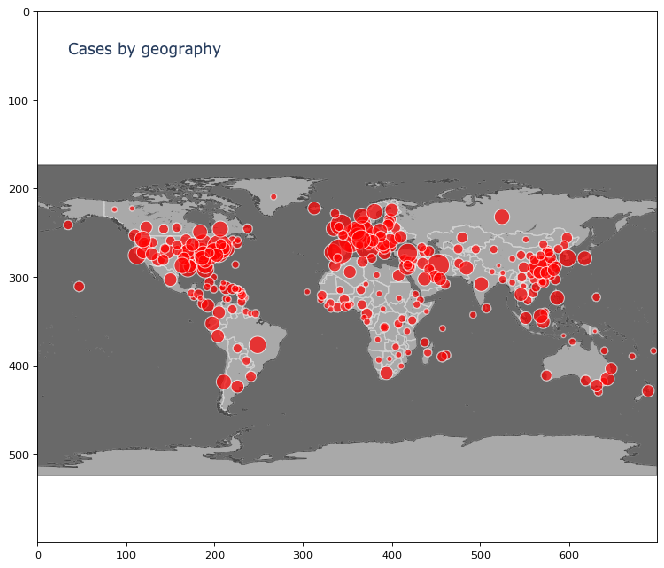

In [47]:
import matplotlib.image as mpimg
import cv2
from matplotlib.pyplot import figure

img=mpimg.imread('newplot_map.png')
figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
imgplot = plt.imshow(img)


In [12]:
lockdown_geo['Location'] = lockdown_geo['Province_State'].astype(str) + '_' + lockdown_geo['Country_Region'].astype(str)


In [13]:
# test_locations = test_features_set[:,6,-1].tolist()
# test_dates = test_features_set[:,6,1].tolist()
# locs = encoders['Location'].inverse_transform([int(i) for i in test_locations]).tolist()
# # [loc for loc in locs if '_US' in loc]

# dates = encoders['Date'].inverse_transform([int(i) for i in test_dates]).tolist()
# # [loc for loc in locs if '_US' in loc]

# Forecast = pd.DataFrame({'Forecasted_cases': out.reshape((len(test_dates),)).tolist(), 'location': locs, 'Date': dates, 'True_cases': test_labels.tolist()})

# US_Forecast = Forecast[Forecast.location.astype(str).str.contains('_US')]



In [14]:
# fig = go.Figure()
# for location in ['0.0_Spain', 'Washington_US', 'Michigan_US']:#US_Forecast.location.unique().tolist():
#     location_df = Forecast[Forecast.location == location]
# #     country_df = lockdown_geo[lockdown_geo.Country_Region == country].groupby(['Date']).agg({'Fatalities': 'sum'}).reset_index()
#     fig.add_trace(go.Scatter(x=location_df.Date, y=location_df.True_cases,
#                         mode='lines+markers',
#                         name=location+' - True Cases'))

#     fig.add_trace(go.Scatter(x=location_df.Date, y=location_df.Forecasted_cases,
#                         mode='lines+markers',
#                         name=location+' - Forecasted Cases'))

#     fig.update_layout(
#         title={
#             'text': "Fatalities over time"})

# fig.show()
    
    